In [2]:
from pycoingecko import CoinGeckoAPI
import time
import pandas as pd
from datetime import datetime

cg = CoinGeckoAPI()

/Users/macsnaxx/Personal Projects/Crypto_Arbitrage/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# demo

In [68]:
coin_id = ['bitcoin', 'monero', 'ethereum', 'litecoin', 'ripple']
vs_currency = 'usd'
data = cg.get_price(ids=coin_id[0], vs_currencies=vs_currency)
# price = data[coin_id][vs_currency]

In [69]:
data

{'bitcoin': {'usd': 113658}}

In [70]:
data = cg.get_coins_markets(vs_currency=vs_currency, ids=coin_id)
df = pd.DataFrame(data, columns=['id', 'symbol', 'name', 'current_price', 'market_cap', 'total_volume'])
df

,id,symbol,name,current_price,market_cap,total_volume
0,bitcoin,btc,Bitcoin,113658.00,2261868219789,32408614812
1,ethereum,eth,Ethereum,3460.73,417652211850,22913529582
2,ripple,xrp,XRP,2.86,169364568408,6321436642
3,litecoin,ltc,Litecoin,108.87,8286104431,887708531
4,monero,xmr,Monero,300.53,5544458798,99829810


In [71]:
data = cg.get_coin_market_chart_by_id(id=['ripple'], vs_currency=vs_currency, days=365)
prices = data['prices']
df = pd.DataFrame(prices, columns=['timestamp', 'price'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [72]:
df['return'] = df['price'].pct_change()
df['return'] = df['return'].fillna(0)


<Axes: title={'center': 'Ripple Return Over Time'}, xlabel='Date', ylabel='Return'>

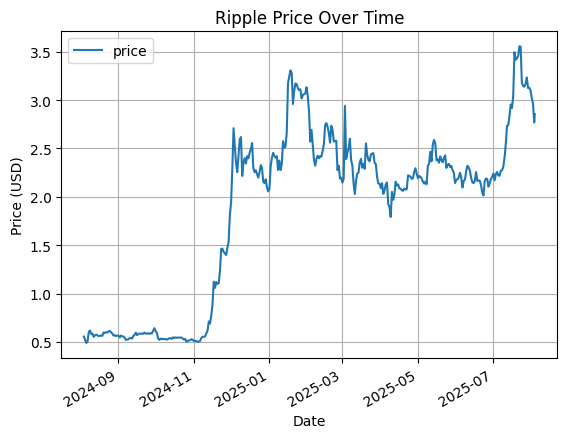

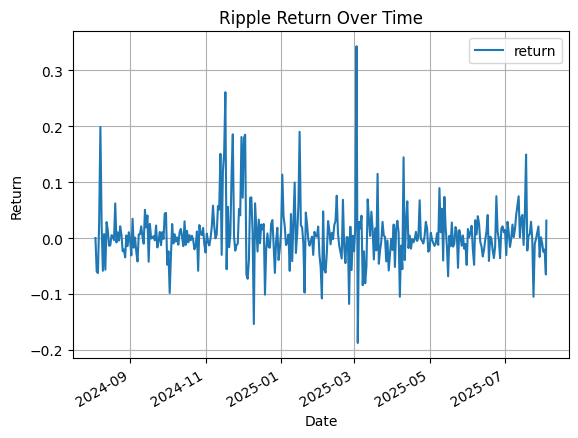

In [73]:
df.plot(x='timestamp', y='price', title='Ripple Price Over Time', xlabel='Date', ylabel='Price (USD)', grid=True)
df.plot(x='timestamp', y='return', title='Ripple Return Over Time', xlabel='Date', ylabel='Return', grid=True)

In [74]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value}')

adf_test(df['price'])

ADF Statistic: -1.3394373553041194
p-value: 0.6109422060295729
Critical Values:
  1%: -3.4483935212959844
  5%: -2.8694912343676497
  10%: -2.571005879151811


In [75]:
adf_test(df['return'])

ADF Statistic: -17.894949745335705
p-value: 2.9680456789486872e-30
Critical Values:
  1%: -3.4483935212959844
  5%: -2.8694912343676497
  10%: -2.571005879151811


# ccxt

In [76]:
import ccxt

In [77]:
pd.to_datetime('1/1/25').timestamp()

1735689600.0

In [78]:
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1m' 
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, pd.to_datetime('2024/1/1').timestamp()*1000)


BadRequest: binance {"code":-1100,"msg":"Illegal characters found in parameter 'startTime'; legal range is '^[0-9]{1,20}$'."}

In [ ]:
since

1735689600000

In [ ]:
ohlcv_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')
ohlcv_df['return'] = ohlcv_df['close'].pct_change()


In [ ]:
len(ohlcv_df)

500

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [ ]:
poloniex_api_key = os.getenv('POLONIEX_API_KEY')  
poloniex_api_secret = os.getenv('POLONIEX_API_SECRET') 

exchange = ccxt.poloniex({
    'apiKey': poloniex_api_key,
    'secret': poloniex_api_secret,
    'enableRateLimit': True,  
    'options': {
        'createMarketBuyOrderRequiresPrice': False
    }
})

In [ ]:
exchange.load_markets()
assert 'XMR/USDT' in exchange.symbols, "XMR/USDT pair not supported"

In [ ]:
balance = exchange.fetch_balance()
xmr_free = balance['free'].get('XMR', 0)
print("Available XMR:", xmr_free)

Available XMR: 3.4e-07


In [ ]:
if xmr_free > 0.006:
    # 3️⃣ Execute market SELL order
    order = exchange.create_market_sell_order('XMR/USDT', xmr_free)
    print("Order executed:", order)

    # 4️⃣ Confirm updated balances
    new_balance = exchange.fetch_balance()
    print("New USDT balance:", new_balance['free'].get('USDT', 0))
else:
    print("No XMR available to sell.")

No XMR available to sell.


In [ ]:
exchange.fetch_balance()

{'info': [{'accountId': '453494102798045184',
   'accountType': 'SPOT',
   'balances': [{'currencyId': '214',
     'currency': 'USDT',
     'available': '1.98615972',
     'hold': '0.00'},
    {'currencyId': '240',
     'currency': 'XMR',
     'available': '0.00000034',
     'hold': '0.00'}]}],
 'timestamp': None,
 'datetime': None,
 'USDT': {'free': 1.98615972, 'used': 0.0, 'total': 1.98615972},
 'XMR': {'free': 3.4e-07, 'used': 0.0, 'total': 3.4e-07},
 'free': {'USDT': 1.98615972, 'XMR': 3.4e-07},
 'used': {'USDT': 0.0, 'XMR': 0.0},
 'total': {'USDT': 1.98615972, 'XMR': 3.4e-07}}

In [ ]:
exchange.fetch_balance()

{'info': [{'accountId': '453494102798045184',
   'accountType': 'SPOT',
   'balances': [{'currencyId': '214',
     'currency': 'USDT',
     'available': '1.98615972',
     'hold': '0.00'},
    {'currencyId': '240',
     'currency': 'XMR',
     'available': '0.00000034',
     'hold': '0.00'}]}],
 'timestamp': None,
 'datetime': None,
 'USDT': {'free': 1.98615972, 'used': 0.0, 'total': 1.98615972},
 'XMR': {'free': 3.4e-07, 'used': 0.0, 'total': 3.4e-07},
 'free': {'USDT': 1.98615972, 'XMR': 3.4e-07},
 'used': {'USDT': 0.0, 'XMR': 0.0},
 'total': {'USDT': 1.98615972, 'XMR': 3.4e-07}}

# offline data

In [31]:
import datetime
df = pd.read_csv("crypto_data_2020-2024/xmrusd.csv")

In [32]:
df.loc[:, 'time'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

/var/folders/3n/bkcdx_js0n56399c9gdw_r2m0000gn/T/ipykernel_2715/1539965637.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2016-12-01 00:04:00' '2016-12-01 00:05:00' '2016-12-01 00:09:00' ...
 '2023-10-08 14:34:00' '2023-10-08 14:41:00' '2023-10-08 14:42:00']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'time'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))


In [34]:
missing = df.isnull().any(axis=1)
max_gap_minutes = 60
missing.sum()

np.int64(0)

In [35]:

gap_lengths = missing.astype(int).groupby((~missing).cumsum()).sum()
long_gaps = gap_lengths[gap_lengths > max_gap_minutes]
if not long_gaps.empty:
    print(f"Found long gaps longer than {max_gap_minutes} minutes: {long_gaps.index.tolist()}")
else:
    print("No long gaps found.")
long_gap_indices = gap_lengths[gap_lengths > max_gap_minutes].index

No long gaps found.


In [100]:
df = df.set_index(pd.DatetimeIndex(df['time'])).drop('time', axis=1)

In [117]:
df2 = df.iloc[-2000:, :]

In [137]:
df.groupby(df.index.date).mean()['close']

2013-04-01       98.764566
2013-04-02      105.576611
2013-04-03      126.405066
2013-04-04      129.492524
2013-04-05      136.269491
                  ...     
2023-10-04    27444.244335
2023-10-05    27708.077140
2023-10-06    27617.064039
2023-10-07    27960.748184
2023-10-08    27951.237705
Name: close, Length: 3707, dtype: float64